<div align="center">
(Failed attemp)

# Biomedical Papers Classification using DSPy 
#### Build and optimize a LLM-based classifier using DSPy with MIPROv2 optimization and MLflow tracking.

---

### 👨‍💻 Author

**Ivan Yang Rodriguez Carranza**

[![Email](https://img.shields.io/badge/Email-D14836?style=for-the-badge&logo=gmail&logoColor=white)](mailto:ivanrodcar@outlook.com)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/irodcar)
[![GitHub](https://img.shields.io/badge/GitHub-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/rodcar)

</div>

---


## 📋 Table of Contents

- [🔧 Setup](#1-setup)
  - [Imports](#imports)
  - [DSPy Configuration](#dspy-configuration)
  - [MLflow Configuration](#mlflow-configuration)
- [📊 Dataset](#2-dataset)
  - [Dataset Download](#dataset-download)
  - [Dataset Loading](#dataset-loading)
  - [Dataset Preview](#dataset-preview)
  - [DSPy Example Conversion](#dspy-example-conversion)
- [⚙️ Core Components](#3-core-components)
  - [DSPy Signature](#dspy-signature)
  - [DSPy Module](#dspy-module)
- [🎯 Prompt Optimization](#4-prompt-optimization)
  - [Optimization Metric](#optimization-metric)
  - [Optimizer](#optimizer)
  - [Optimization Process](#optimization-process)
  - [Optimized DSPy Signature](#optimized-dspy-signature)
  - [Optimized Examples](#optimized-examples-few-shot-examples)
- [📈 Prompt Evaluation](#5-prompt-evaluation)
  - [Evaluator](#evaluator)
  - [Baseline Evaluation](#baseline-evaluation)
  - [Optimized Prompt Evaluation](#optimized-prompt-evaluation)
  - [Comparison](#comparison)
- [💾 Save & Load DSPy Programs](#6-save--load-dspy-programs)
  - [Saving DSPy Programs](#saving-dspy-programs)
  - [Loading DSPy Programs](#loading-dspy-programs)

## 1. Setup

### Imports
Required libraries for DSPy, MLflow, and data processing.

In [1]:
import os
import uuid
from dotenv import load_dotenv
import dspy
import mlflow
import polars as pl

### DSPy Configuration
Initialize language model and configure DSPy settings

In [ ]:
# Load environment variables from .env file
load_dotenv()

# Programs folder
PROGRAMS_FOLDER = "programs"

# Get model ID from environment or use default
MODEL_ID = os.getenv("MODEL_ID", "openai/gpt-4o-mini")

# Initialize DSPy language model
# For OpenAI reasoning models, temperature=1.0 and max_tokens >= 20000 are required
lm = dspy.LM(MODEL_ID, temperature=1.0, max_tokens=20000)

# Configure DSPy with the language model
dspy.settings.configure(lm=lm)

### MLflow Configuration

Run `mlflow ui --port 8080` in a terminal before executing this cell.

In [3]:
mlflow.set_tracking_uri(uri=os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:8080"))
mlflow.set_experiment(f"dspy_biomedic_classifier_{str(uuid.uuid4())[:8]}")
mlflow.dspy.autolog(log_evals=True, log_compiles=True, log_traces_from_compile=True)

2025/08/21 21:07:24 INFO mlflow.tracking.fluent: Experiment with name 'dspy_biomedic_classifier_72c9b5f9' does not exist. Creating a new experiment.


## 2. Dataset

Load the biomedical papers dataset, preprocess it, and convert to DSPy format for training and evaluation.

In [4]:
# Dataset already available locally
print("Using local biomedical papers dataset...")
dataset_path = "../data/challenge_data-18-ago.csv"
print(f"Dataset path: {dataset_path}")

Using local biomedical papers dataset...
Dataset path: ../data/challenge_data-18-ago.csv


### Dataset Loading

In [ ]:
print("=" * 60)
print(f"Loading dataset from: {dataset_path}")
dataset = pl.read_csv(dataset_path, separator=";")
print(f"Rows: {dataset.shape[0]} | Columns: {dataset.shape[1]}")
print(f"Columns: {dataset.columns}")
print("-" * 60)

print("Sampling 500 rows for processing...")
dataset = dataset.sample(seed=42)
print(f"Sampled dataset shape: {dataset.shape}")

print("-" * 60)
print("Converting group column to multi-label boolean columns...")

# Create boolean columns for each medical category
dataset = dataset.with_columns([
    pl.col('group').str.contains('neurological').fill_null(False).alias('neurological'),
    pl.col('group').str.contains('cardiovascular').fill_null(False).alias('cardiovascular'), 
    pl.col('group').str.contains('hepatorenal').fill_null(False).alias('hepatorenal'),
    pl.col('group').str.contains('oncological').fill_null(False).alias('oncological')
])

# Drop the original group column
dataset = dataset.drop('group')

print(f"Dataset shape after adding boolean columns: {dataset.shape}")
print(f"New columns: {dataset.columns}")

print("-" * 60)
print("Splitting dataset: 80% train / 20% validation")
split_idx = int(0.8 * len(dataset))
trainset = dataset[:split_idx]
valset = dataset[split_idx:]
print(f"Training set:   {trainset.shape[0]} rows")
print(f"Validation set: {valset.shape[0]} rows")
print("=" * 60)

Loading dataset from: ../data/challenge_data-18-ago.csv
Rows: 3565 | Columns: 3
Columns: ['title', 'abstract', 'group']
------------------------------------------------------------
Sampling 500 rows for processing...
Sampled dataset shape: (500, 3)
------------------------------------------------------------
Converting group column to multi-label boolean columns...
Dataset shape after adding boolean columns: (500, 6)
New columns: ['title', 'abstract', 'neurological', 'cardiovascular', 'hepatorenal', 'oncological']
------------------------------------------------------------
Splitting dataset: 80% train / 20% validation
Training set:   400 rows
Validation set: 100 rows


In [6]:
print("Boolean column distributions in training set:")
for col in ['neurological', 'cardiovascular', 'hepatorenal', 'oncological']:
    true_count = trainset[col].sum()
    false_count = len(trainset) - true_count
    percentage = (true_count / len(trainset)) * 100
    print(f"  - {col}: {true_count} True ({percentage:.1f}%), {false_count} False ({100-percentage:.1f}%)")

print("\nSample label combinations:")
# Show first 10 rows of boolean columns
sample_labels = trainset.select(['neurological', 'cardiovascular', 'hepatorenal', 'oncological']).head(10)
for i, row in enumerate(sample_labels.iter_rows(named=True)):
    active_labels = [col for col, val in row.items() if val]
    label_str = '|'.join(active_labels) if active_labels else 'None'
    print(f"  Row {i+1}: {label_str}")

Boolean column distributions in training set:
  - neurological: 207 True (51.7%), 193 False (48.3%)
  - cardiovascular: 155 True (38.8%), 245 False (61.2%)
  - hepatorenal: 113 True (28.2%), 287 False (71.8%)
  - oncological: 65 True (16.2%), 335 False (83.8%)

Sample label combinations:
  Row 1: cardiovascular
  Row 2: neurological|cardiovascular
  Row 3: oncological
  Row 4: neurological
  Row 5: neurological|hepatorenal
  Row 6: cardiovascular
  Row 7: neurological
  Row 8: cardiovascular
  Row 9: hepatorenal
  Row 10: cardiovascular|hepatorenal


### Dataset Preview

In [7]:
trainset.head()

title,abstract,neurological,cardiovascular,hepatorenal,oncological
str,str,bool,bool,bool,bool
"""hypertension and atheroscleros…","""Aim: To investigate ACE inhibi…",false,true,false,false
"""When norepinephrine meets hepa…","""Hypothesis: statins improves d…",true,true,false,false
"""Cyclophosphamide associated bl…","""PURPOSE: We gained knowledge o…",false,false,false,true
"""The human MAGEL2 gene and its …","""Prader-Willi syndrome ( PWS ) …",true,false,false,false
"""When cirrhosis meets lung canc…","""Study design: longitudinal inv…",true,false,true,false


### DSPy Example Conversion

Convert the sets into DSPy Example objects for prompt optimization and validation.

In [8]:
def to_dspy_examples(dataset):
    examples = []
    for item in dataset.iter_rows(named=True):
        example = dspy.Example(
            title=item["title"],
            abstract=item["abstract"],
            neurological=item["neurological"],
            cardiovascular=item["cardiovascular"],
            hepatorenal=item["hepatorenal"],
            oncological=item["oncological"]
        ).with_inputs("title", "abstract")
        examples.append(example)
    return examples

dspy_trainset = to_dspy_examples(trainset)
dspy_valset = to_dspy_examples(valset)

print(f"Created {len(dspy_trainset)} dspy.Example objects for training")
print(f"Created {len(dspy_valset)} dspy.Example objects for validation")

Created 400 dspy.Example objects for training
Created 100 dspy.Example objects for validation


## 3. Core Components

### DSPy Signature

In [9]:
class NeurologicalClassifier(dspy.Signature):
    """Classifies if a biomedical paper is related to neurological conditions."""
    title: str = dspy.InputField(desc="Title of the biomedical paper")
    abstract: str = dspy.InputField(desc="Abstract of the biomedical paper")
    is_neurological: bool = dspy.OutputField(desc="True if the paper is related to neurological conditions")

class CardiovascularClassifier(dspy.Signature):
    """Classifies if a biomedical paper is related to cardiovascular conditions."""
    title: str = dspy.InputField(desc="Title of the biomedical paper")
    abstract: str = dspy.InputField(desc="Abstract of the biomedical paper")
    is_cardiovascular: bool = dspy.OutputField(desc="True if the paper is related to cardiovascular conditions")

class HepatoRenalClassifier(dspy.Signature):
    """Classifies if a biomedical paper is related to hepatorenal conditions."""
    title: str = dspy.InputField(desc="Title of the biomedical paper")
    abstract: str = dspy.InputField(desc="Abstract of the biomedical paper")
    is_hepatorenal: bool = dspy.OutputField(desc="True if the paper is related to hepatorenal conditions")

class OncologicalClassifier(dspy.Signature):
    """Classifies if a biomedical paper is related to oncological conditions."""
    title: str = dspy.InputField(desc="Title of the biomedical paper")
    abstract: str = dspy.InputField(desc="Abstract of the biomedical paper")
    is_oncological: bool = dspy.OutputField(desc="True if the paper is related to oncological conditions")

### DSPy Module  

In [10]:
# Create 4 separate classifiers - one per medical category
neurological_classifier = dspy.Predict(NeurologicalClassifier)
cardiovascular_classifier = dspy.Predict(CardiovascularClassifier)
hepatorenal_classifier = dspy.Predict(HepatoRenalClassifier)
oncological_classifier = dspy.Predict(OncologicalClassifier)

# Group them for easier handling
classifiers = {
    'neurological': neurological_classifier,
    'cardiovascular': cardiovascular_classifier,
    'hepatorenal': hepatorenal_classifier,
    'oncological': oncological_classifier
}

## 4. Prompt Optimization

Use MIPROv2 to optimize prompts through automated prompt engineering and few-shot example selection.


### Optimization Metric


Before optimizing we need to define a evalution metric.

In [11]:
# Individual evaluation metrics for each classifier
def neurological_accuracy(example, pred, trace=None):
    """Accuracy metric for neurological classifier."""
    return getattr(pred, 'is_neurological', False) == example.neurological

def cardiovascular_accuracy(example, pred, trace=None):
    """Accuracy metric for cardiovascular classifier."""
    return getattr(pred, 'is_cardiovascular', False) == example.cardiovascular

def hepatorenal_accuracy(example, pred, trace=None):
    """Accuracy metric for hepatorenal classifier."""
    return getattr(pred, 'is_hepatorenal', False) == example.hepatorenal

def oncological_accuracy(example, pred, trace=None):
    """Accuracy metric for oncological classifier."""
    return getattr(pred, 'is_oncological', False) == example.oncological

# Group metrics for easy access
metrics = {
    'neurological': neurological_accuracy,
    'cardiovascular': cardiovascular_accuracy,
    'hepatorenal': hepatorenal_accuracy,
    'oncological': oncological_accuracy
}

### Optimizer

In [ ]:
# Individual optimizers for each classifier
optimizers = {}
for category, metric in metrics.items():
    optimizers[category] = dspy.MIPROv2(
        metric=metric,
        auto="heavy", 
        num_threads=16
    )
    print(f"Created optimizer for {category} classifier")

Created optimizer for neurological classifier
Created optimizer for cardiovascular classifier
Created optimizer for hepatorenal classifier
Created optimizer for oncological classifier


### Optimization Process

In [13]:
# Optimize each classifier individually
optimized_classifiers = {}

for category in ['neurological', 'cardiovascular', 'hepatorenal', 'oncological']:
    print(f"\n{'='*60}")
    print(f"OPTIMIZING {category.upper()} CLASSIFIER")
    print(f"{'='*60}")
    
    optimized_classifiers[category] = optimizers[category].compile(
        classifiers[category],
        trainset=dspy_trainset,
        valset=dspy_valset,
        requires_permission_to_run=False,
    )
    
    print(f"✅ {category} classifier optimization completed!")

print(f"\n{'='*60}")
print("ALL CLASSIFIERS OPTIMIZED SUCCESSFULLY!")
print(f"{'='*60}")


OPTIMIZING NEUROLOGICAL CLASSIFIER


2025/08/21 21:07:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3eb227fb78264d24b8c9b65f64e51a6c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current dspy workflow
2025/08/21 21:07:25 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 100

2025/08/21 21:07:25 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/21 21:07:25 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/21 21:07:25 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


2025/08/21 21:07:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ivan/Workspace/dspy-projects/dspy-biomedic-papers-classifier/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html"
  1%|          | 4/400 [00:05<09:15,  1.40s/it]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Bootstrapping set 4/6


  0%|          | 1/400 [00:00<03:57,  1.68it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 5/6


  0%|          | 2/400 [00:01<04:48,  1.38it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 6/6


  0%|          | 2/400 [00:01<05:43,  1.16it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


2025/08/21 21:07:35 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/21 21:07:35 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/21 21:09:10 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/08/21 21:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/21 21:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Classifies if a biomedical paper is related to neurological conditions.

2025/08/21 21:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Given the title and abstract of a biomedical research article, determine whether the article primarily pertains to the field of neurology. Analyze the content for references to neurological systems, diseases, pathways, or concepts (such as brain, neurons

Average Metric: 70.00 / 100 (70.0%): 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]

2025/08/21 21:09:50 INFO dspy.evaluate.evaluate: Average Metric: 70 / 100 (70.0%)



🏃 View run eval_full_0 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/cfe9e10d0f65438ba7719af025b23765
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:09:50 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 70.0

2025/08/21 21:09:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|██████████| 35/35 [00:02<00:00, 13.14it/s]

2025/08/21 21:09:53 INFO dspy.evaluate.evaluate: Average Metric: 30 / 35 (85.7%)



🏃 View run eval_minibatch_0 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/7359304fbb824731969065b7fee2c1df
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:09:53 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/21 21:09:53 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71]
2025/08/21 21:09:53 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/21 21:09:53 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/21 21:09:53 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:09:53 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [00:02<00:00, 11.86it/s]

2025/08/21 21:09:56 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)



🏃 View run eval_minibatch_1 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/5829c68ed47e40a2909993ada4035e83
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:09:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/21 21:09:57 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43]
2025/08/21 21:09:57 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/21 21:09:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/21 21:09:57 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:09:57 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==


Average Metric: 33.00 / 35 (94.3%): 100%|██████████| 35/35 [00:03<00:00, 10.82it/s]

2025/08/21 21:10:00 INFO dspy.evaluate.evaluate: Average Metric: 33 / 35 (94.3%)



🏃 View run eval_minibatch_2 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/d37f3bcc4d80436094642cde8c47e963
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:10:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 94.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:10:00 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43, 94.29]
2025/08/21 21:10:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/21 21:10:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/21 21:10:00 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:10:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [00:03<00:00,  9.40it/s]

2025/08/21 21:10:04 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)



🏃 View run eval_minibatch_3 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/36817139dafe431ea43501719ab68607
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:10:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/08/21 21:10:04 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43, 94.29, 71.43]
2025/08/21 21:10:04 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/21 21:10:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/21 21:10:04 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:10:04 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|██████████| 35/35 [00:03<00:00, 10.37it/s]

2025/08/21 21:10:08 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)



🏃 View run eval_minibatch_4 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/833074bea8dc47f7ab660b64f77f342a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:10:08 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:10:08 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43, 94.29, 71.43, 74.29]
2025/08/21 21:10:08 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/21 21:10:08 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/21 21:10:08 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:10:08 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/08/21 21:10:08 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 94.29) from minibatch trials...


Average Metric: 78.00 / 100 (78.0%): 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]

2025/08/21 21:10:15 INFO dspy.evaluate.evaluate: Average Metric: 78 / 100 (78.0%)


2025/08/21 21:10:16 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 78.0
2025/08/21 21:10:16 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 78.0]
2025/08/21 21:10:16 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:10:16 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/21 21:10:16 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/21 21:10:16 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==


🏃 View run eval_full_1 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/662637e05bd44b708e63a3ebe6a0379e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 28.00 / 35 (80.0%): 100%|██████████| 35/35 [00:02<00:00, 14.04it/s]

2025/08/21 21:10:18 INFO dspy.evaluate.evaluate: Average Metric: 28 / 35 (80.0%)


2025/08/21 21:10:19 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/21 21:10:19 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43, 94.29, 71.43, 74.29, 80.0]
2025/08/21 21:10:19 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 78.0]
2025/08/21 21:10:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:10:19 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:10:19 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==


🏃 View run eval_minibatch_5 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/3ed04e336a3541438c81299cf3bce89b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [00:04<00:00,  8.32it/s]

2025/08/21 21:10:23 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)


2025/08/21 21:10:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:10:23 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43, 94.29, 71.43, 74.29, 80.0, 68.57]
2025/08/21 21:10:23 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 78.0]
2025/08/21 21:10:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:10:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:10:23 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==


🏃 View run eval_minibatch_6 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/137957d4486442718a9c78486f5e3a2b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 32.00 / 35 (91.4%): 100%|██████████| 35/35 [00:04<00:00,  8.26it/s]

2025/08/21 21:10:28 INFO dspy.evaluate.evaluate: Average Metric: 32 / 35 (91.4%)


2025/08/21 21:10:28 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 91.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/21 21:10:28 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43, 94.29, 71.43, 74.29, 80.0, 68.57, 91.43]
2025/08/21 21:10:28 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 78.0]
2025/08/21 21:10:28 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:10:28 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:10:28 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


🏃 View run eval_minibatch_7 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/1f063bdc516148bcacf13d25ef237812
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:02<00:00, 12.89it/s]

2025/08/21 21:10:31 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)


2025/08/21 21:10:31 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:10:31 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43, 94.29, 71.43, 74.29, 80.0, 68.57, 91.43, 65.71]
2025/08/21 21:10:31 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 78.0]
2025/08/21 21:10:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:10:31 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:10:31 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


🏃 View run eval_minibatch_8 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/e2a83db70d424a349c8a9a3d6bdb495b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [00:03<00:00,  9.94it/s]

2025/08/21 21:10:35 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)


2025/08/21 21:10:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/21 21:10:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 71.43, 94.29, 71.43, 74.29, 80.0, 68.57, 91.43, 65.71, 62.86]
2025/08/21 21:10:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 78.0]
2025/08/21 21:10:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:10:36 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:10:36 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/08/21 21:10:36 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 85.71) from minibatch trials...


🏃 View run eval_minibatch_9 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/f6a1e24c04204d59ac2dfcaae721df80
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 82.00 / 100 (82.0%): 100%|██████████| 100/100 [00:09<00:00, 10.08it/s]

2025/08/21 21:10:46 INFO dspy.evaluate.evaluate: Average Metric: 82 / 100 (82.0%)


2025/08/21 21:10:46 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 82.0
2025/08/21 21:10:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 78.0, 82.0]
2025/08/21 21:10:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 82.0
2025/08/21 21:10:46 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/21 21:10:46 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/21 21:10:46 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 82.0!


🏃 View run eval_full_2 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/a8adc26ac4044ef6b76807949ee188e0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:10:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ba955584bb5e4ffa9faf691a1ea06450', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current dspy workflow
2025/08/21 21:10:47 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 100

2025/08/21 21:10:47 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/21 21:10:47 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/21 21:10:47 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


🏃 View run skillful-snail-771 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/3eb227fb78264d24b8c9b65f64e51a6c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ neurological classifier optimization completed!

OPTIMIZING CARDIOVASCULAR CLASSIFIER
Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  0%|          | 0/400 [00:00<?, ?it/s]/Users/ivan/Workspace/dspy-projects/dspy-biomedic-papers-classifier/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 6: Expected `Message` - serialized value may not be as expected [input_value=Message(content='[[ ## is...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
  2%|▏         | 6/400 [00:05<06:15,  1.05it/s]


Bootstrapped 4 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Bootstrapping set 4/6


  1%|          | 3/400 [00:03<06:41,  1.01s/it]


Bootstrapped 1 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 5/6


  1%|          | 3/400 [00:02<05:54,  1.12it/s]


Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 6/6


  0%|          | 2/400 [00:01<05:42,  1.16it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


2025/08/21 21:11:03 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/21 21:11:03 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/21 21:11:04 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/08/21 21:11:33 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/21 21:11:33 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Classifies if a biomedical paper is related to cardiovascular conditions.

2025/08/21 21:11:33 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Given the title and abstract of a biomedical research article, determine whether the article is primarily related to cardiovascular topics (such as heart disease, blood vessels, hypertension, or other cardiovascular conditions). Analyze both the explic

Average Metric: 75.00 / 100 (75.0%): 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]

2025/08/21 21:11:43 INFO dspy.evaluate.evaluate: Average Metric: 75 / 100 (75.0%)


2025/08/21 21:11:44 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 75.0

2025/08/21 21:11:44 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


🏃 View run eval_full_0 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/2999e3fd3a8345d3ab91dff10a798711
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [00:06<00:00,  5.42it/s]

2025/08/21 21:11:50 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)


2025/08/21 21:11:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/21 21:11:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86]
2025/08/21 21:11:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0]
2025/08/21 21:11:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 75.0
2025/08/21 21:11:51 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:11:51 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


🏃 View run eval_minibatch_0 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/704cdd49d0ea42c79853863fc5388a27
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 29.00 / 35 (82.9%): 100%|██████████| 35/35 [00:03<00:00,  9.04it/s]

2025/08/21 21:11:55 INFO dspy.evaluate.evaluate: Average Metric: 29 / 35 (82.9%)


2025/08/21 21:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/21 21:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86]
2025/08/21 21:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0]
2025/08/21 21:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 75.0
2025/08/21 21:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==


🏃 View run eval_minibatch_1 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/f4f55286b2da4363b18b1fde1bccf686
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 26.00 / 35 (74.3%): 100%|██████████| 35/35 [00:09<00:00,  3.76it/s]

2025/08/21 21:12:05 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)


2025/08/21 21:12:06 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:12:06 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86, 74.29]
2025/08/21 21:12:06 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0]
2025/08/21 21:12:06 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 75.0
2025/08/21 21:12:06 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:12:06 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


🏃 View run eval_minibatch_2 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/ae895b8ce24a41c0b94695b2325808f0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [00:06<00:00,  5.30it/s]

2025/08/21 21:12:12 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)


2025/08/21 21:12:13 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/08/21 21:12:13 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86, 74.29, 77.14]
2025/08/21 21:12:13 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0]
2025/08/21 21:12:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 75.0
2025/08/21 21:12:13 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:12:13 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==


🏃 View run eval_minibatch_3 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/227e72b9287f49c7994a4438ec1d9087
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 30.00 / 35 (85.7%): 100%|██████████| 35/35 [00:05<00:00,  5.91it/s]

2025/08/21 21:12:19 INFO dspy.evaluate.evaluate: Average Metric: 30 / 35 (85.7%)


2025/08/21 21:12:20 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:12:20 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86, 74.29, 77.14, 85.71]
2025/08/21 21:12:20 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0]
2025/08/21 21:12:20 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 75.0
2025/08/21 21:12:20 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:12:20 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/08/21 21:12:20 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 85.71) from minibatch trials...


🏃 View run eval_minibatch_4 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/bc6d906a770b4f54b7c826fdd80f3722
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
Average Metric: 78.00 / 100 (78.0%): 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]

2025/08/21 21:12:36 INFO dspy.evaluate.evaluate: Average Metric: 78 / 100 (78.0%)



🏃 View run eval_full_1 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/d63ff1042f4647919349c57ae29bd238
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:12:37 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 78.0
2025/08/21 21:12:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0, 78.0]
2025/08/21 21:12:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:12:37 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/21 21:12:37 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/21 21:12:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==


Average Metric: 33.00 / 35 (94.3%): 100%|██████████| 35/35 [00:03<00:00,  9.83it/s]

2025/08/21 21:12:41 INFO dspy.evaluate.evaluate: Average Metric: 33 / 35 (94.3%)



🏃 View run eval_minibatch_5 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/a096c2b378fe488ea94a536232ab3843
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:12:42 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 94.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/21 21:12:42 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86, 74.29, 77.14, 85.71, 94.29]
2025/08/21 21:12:42 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0, 78.0]
2025/08/21 21:12:42 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:12:42 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:12:42 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==


Average Metric: 31.00 / 35 (88.6%): 100%|██████████| 35/35 [00:06<00:00,  5.23it/s]

2025/08/21 21:12:49 INFO dspy.evaluate.evaluate: Average Metric: 31 / 35 (88.6%)



🏃 View run eval_minibatch_6 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/68499b85fcc34b40a4bef53951441842
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:12:49 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:12:49 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86, 74.29, 77.14, 85.71, 94.29, 88.57]
2025/08/21 21:12:49 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0, 78.0]
2025/08/21 21:12:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:12:49 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:12:49 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|██████████| 35/35 [00:06<00:00,  5.77it/s]

2025/08/21 21:12:56 INFO dspy.evaluate.evaluate: Average Metric: 30 / 35 (85.7%)



🏃 View run eval_minibatch_7 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/837cb8692fb34818813b177229dfcfad
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:12:56 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/21 21:12:56 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86, 74.29, 77.14, 85.71, 94.29, 88.57, 85.71]
2025/08/21 21:12:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0, 78.0]
2025/08/21 21:12:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:12:56 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:12:56 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


Average Metric: 31.00 / 35 (88.6%): 100%|██████████| 35/35 [00:06<00:00,  5.39it/s] 

2025/08/21 21:13:03 INFO dspy.evaluate.evaluate: Average Metric: 31 / 35 (88.6%)



🏃 View run eval_minibatch_8 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/391ab3c4ab0c4f1f86fd76938a1aec5b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:13:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 4'].
2025/08/21 21:13:04 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86, 74.29, 77.14, 85.71, 94.29, 88.57, 85.71, 88.57]
2025/08/21 21:13:04 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0, 78.0]
2025/08/21 21:13:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:13:04 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:13:04 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


Average Metric: 32.00 / 35 (91.4%): 100%|██████████| 35/35 [00:05<00:00,  5.99it/s]

2025/08/21 21:13:10 INFO dspy.evaluate.evaluate: Average Metric: 32 / 35 (91.4%)



🏃 View run eval_minibatch_9 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/3a7fea1048504170a338f6d76531cdb9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 91.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 82.86, 74.29, 77.14, 85.71, 94.29, 88.57, 85.71, 88.57, 91.43]
2025/08/21 21:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0, 78.0]
2025/08/21 21:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.0
2025/08/21 21:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/08/21 21:13:11 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 90.0) from minibatch trials...


Average Metric: 91.00 / 100 (91.0%): 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]

2025/08/21 21:13:28 INFO dspy.evaluate.evaluate: Average Metric: 91 / 100 (91.0%)



🏃 View run eval_full_2 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/5edcccea2cdd4bb1ba748c8941abbaaa
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:13:29 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 91.0
2025/08/21 21:13:29 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [75.0, 78.0, 91.0]
2025/08/21 21:13:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 91.0
2025/08/21 21:13:29 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/21 21:13:29 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/21 21:13:29 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 91.0!
2025/08/21 21:13:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fc4bedcd040a4f2ba6d5a078ee222d66', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current dspy workflow
2025/08/21 21:13:30 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_cand

🏃 View run invincible-crane-7 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/ba955584bb5e4ffa9faf691a1ea06450
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ cardiovascular classifier optimization completed!

OPTIMIZING HEPATORENAL CLASSIFIER
Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  0%|          | 0/400 [00:00<?, ?it/s]/Users/ivan/Workspace/dspy-projects/dspy-biomedic-papers-classifier/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 6: Expected `Message` - serialized value may not be as expected [input_value=Message(content='[[ ## is...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
  1%|          | 4/400 [00:04<07:09,  1.09s/it]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Bootstrapping set 4/6


  0%|          | 1/400 [00:00<06:30,  1.02it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 5/6


  0%|          | 2/400 [00:01<05:24,  1.23it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 6/6


  0%|          | 2/400 [00:02<07:08,  1.08s/it]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


2025/08/21 21:13:45 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/21 21:13:45 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/21 21:13:46 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/08/21 21:14:16 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/21 21:14:16 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Classifies if a biomedical paper is related to hepatorenal conditions.

2025/08/21 21:14:16 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Given the title and abstract of a biomedical research article, determine whether the article discusses hepatorenal conditions—medical issues that involve both the liver and kidneys, such as hepatorenal syndrome or diseases affecting both organs. Analyze t

Average Metric: 73.00 / 100 (73.0%): 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]

2025/08/21 21:14:31 INFO dspy.evaluate.evaluate: Average Metric: 73 / 100 (73.0%)



🏃 View run eval_full_0 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/dcad83a83f974cec9ee5915ae75e77ec
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:14:32 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 73.0

2025/08/21 21:14:32 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:08<00:00,  4.27it/s]

2025/08/21 21:14:40 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)



🏃 View run eval_minibatch_0 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/16e8b8410be74049849f8928b0588e61
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:14:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/21 21:14:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71]
2025/08/21 21:14:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/21 21:14:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/21 21:14:41 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:14:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:05<00:00,  6.08it/s]

2025/08/21 21:14:47 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)



🏃 View run eval_minibatch_1 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/a2542cf962564c99aa5e43b54e29b836
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:14:48 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/21 21:14:48 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71]
2025/08/21 21:14:48 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/21 21:14:48 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/21 21:14:48 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:14:48 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==


Average Metric: 28.00 / 35 (80.0%): 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]

2025/08/21 21:14:57 INFO dspy.evaluate.evaluate: Average Metric: 28 / 35 (80.0%)



🏃 View run eval_minibatch_2 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/56d210c3f29946f78f421ccb889744df
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:14:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:14:58 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71, 80.0]
2025/08/21 21:14:58 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/21 21:14:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/21 21:14:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:14:58 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]

2025/08/21 21:15:06 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)



🏃 View run eval_minibatch_3 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/00dcfcfe7b60419fbd08c81013cc09f6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:15:08 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/08/21 21:15:08 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71, 80.0, 77.14]
2025/08/21 21:15:08 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/21 21:15:08 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/21 21:15:08 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:15:08 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|██████████| 35/35 [00:08<00:00,  4.17it/s] 

2025/08/21 21:15:16 INFO dspy.evaluate.evaluate: Average Metric: 29 / 35 (82.9%)



🏃 View run eval_minibatch_4 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/3029f22d59ac4b2e9642025180903219
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:15:17 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:15:17 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71, 80.0, 77.14, 82.86]
2025/08/21 21:15:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/21 21:15:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/21 21:15:17 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:15:17 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/08/21 21:15:17 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 82.86) from minibatch trials...


Average Metric: 84.00 / 100 (84.0%): 100%|██████████| 100/100 [00:22<00:00,  4.51it/s]

2025/08/21 21:15:40 INFO dspy.evaluate.evaluate: Average Metric: 84 / 100 (84.0%)



🏃 View run eval_full_1 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/c4796287b13c49a09aea07ef715efeff
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:15:41 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 84.0
2025/08/21 21:15:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 84.0]
2025/08/21 21:15:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.0
2025/08/21 21:15:41 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/21 21:15:41 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/21 21:15:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [00:09<00:00,  3.63it/s]

2025/08/21 21:15:51 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)



🏃 View run eval_minibatch_5 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/9c9488f552ce44f1b18cc58e6bf9ef45
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:15:52 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/21 21:15:52 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71, 80.0, 77.14, 82.86, 62.86]
2025/08/21 21:15:52 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 84.0]
2025/08/21 21:15:52 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.0
2025/08/21 21:15:52 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:15:52 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]

2025/08/21 21:16:39 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)



🏃 View run eval_minibatch_6 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/57dc79d04ef64405a95601c3a55a55f4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:16:40 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:16:40 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71, 80.0, 77.14, 82.86, 62.86, 62.86]
2025/08/21 21:16:40 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 84.0]
2025/08/21 21:16:40 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.0
2025/08/21 21:16:40 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:16:40 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==


Average Metric: 31.00 / 35 (88.6%): 100%|██████████| 35/35 [00:08<00:00,  3.91it/s]

2025/08/21 21:16:49 INFO dspy.evaluate.evaluate: Average Metric: 31 / 35 (88.6%)



🏃 View run eval_minibatch_7 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/2f7212aa46b14d4abbd227139f1c3c30
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/21 21:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71, 80.0, 77.14, 82.86, 62.86, 62.86, 88.57]
2025/08/21 21:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 84.0]
2025/08/21 21:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.0
2025/08/21 21:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]

2025/08/21 21:16:59 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)



🏃 View run eval_minibatch_8 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/5e7a320d10984241a849ce212e094c44
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:17:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/21 21:17:00 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71, 80.0, 77.14, 82.86, 62.86, 62.86, 88.57, 77.14]
2025/08/21 21:17:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 84.0]
2025/08/21 21:17:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.0
2025/08/21 21:17:00 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:17:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


Average Metric: 32.00 / 35 (91.4%): 100%|██████████| 35/35 [00:08<00:00,  3.89it/s] 

2025/08/21 21:17:10 INFO dspy.evaluate.evaluate: Average Metric: 32 / 35 (91.4%)



🏃 View run eval_minibatch_9 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/d1eea22ff3534e2198cb2a422492a2e2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:17:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 91.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 4'].
2025/08/21 21:17:11 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [65.71, 65.71, 80.0, 77.14, 82.86, 62.86, 62.86, 88.57, 77.14, 91.43]
2025/08/21 21:17:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 84.0]
2025/08/21 21:17:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.0
2025/08/21 21:17:11 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:17:11 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/08/21 21:17:11 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 91.43) from minibatch trials...


Average Metric: 89.00 / 100 (89.0%): 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]

2025/08/21 21:17:37 INFO dspy.evaluate.evaluate: Average Metric: 89 / 100 (89.0%)



🏃 View run eval_full_2 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/3ee12114f10d4e78bba72b5b4431029c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 89.0
2025/08/21 21:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 84.0, 89.0]
2025/08/21 21:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 89.0
2025/08/21 21:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/21 21:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/21 21:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 89.0!


🏃 View run crawling-fawn-7 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/fc4bedcd040a4f2ba6d5a078ee222d66
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ hepatorenal classifier optimization completed!

OPTIMIZING ONCOLOGICAL CLASSIFIER


2025/08/21 21:17:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1c322968155d4f9cb3a59d6a08b00da8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current dspy workflow
2025/08/21 21:17:40 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 100

2025/08/21 21:17:40 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/21 21:17:40 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/21 21:17:40 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  0%|          | 0/400 [00:00<?, ?it/s]/Users/ivan/Workspace/dspy-projects/dspy-biomedic-papers-classifier/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 6: Expected `Message` - serialized value may not be as expected [input_value=Message(content='[[ ## is...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
  1%|          | 4/400 [00:04<07:46,  1.18s/it]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Bootstrapping set 4/6


  0%|          | 1/400 [00:01<10:10,  1.53s/it]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 5/6


  1%|          | 4/400 [00:05<09:12,  1.39s/it]


Bootstrapped 2 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Bootstrapping set 6/6


  0%|          | 2/400 [00:01<06:17,  1.05it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


2025/08/21 21:18:01 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/21 21:18:01 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/21 21:18:03 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/08/21 21:18:26 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/21 21:18:26 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Classifies if a biomedical paper is related to oncological conditions.

2025/08/21 21:18:26 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Given the title and abstract of a biomedical research article, analyze the content and determine whether the article is related to oncology (the study, diagnosis, treatment, or biology of cancer). Consider explicit mentions of cancer types, tumors, carcin

Average Metric: 67.00 / 100 (67.0%): 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]

2025/08/21 21:18:47 INFO dspy.evaluate.evaluate: Average Metric: 67 / 100 (67.0%)



🏃 View run eval_full_0 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/24d8b396c9ac4013ae6a304bbac3e3c5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:18:48 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 67.0

2025/08/21 21:18:48 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|██████████| 35/35 [00:11<00:00,  2.95it/s]

2025/08/21 21:19:00 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)



🏃 View run eval_minibatch_0 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/386b9a7887604799b94ec12da9f1dfcf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:19:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/21 21:19:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29]
2025/08/21 21:19:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/21 21:19:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:19:02 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:19:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [00:08<00:00,  3.94it/s]

2025/08/21 21:19:11 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)



🏃 View run eval_minibatch_1 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/e5f5654585c043b58f658476518ee6ba
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:19:12 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/21 21:19:12 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86]
2025/08/21 21:19:12 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/21 21:19:12 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:19:12 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:19:12 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [00:10<00:00,  3.30it/s]

2025/08/21 21:19:24 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)



🏃 View run eval_minibatch_2 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/6eca5ecc36e54b50848673ac15771744
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:19:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:19:25 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 71.43]
2025/08/21 21:19:25 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/21 21:19:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:19:25 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:19:25 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]

2025/08/21 21:19:36 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)



🏃 View run eval_minibatch_3 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/d213761df0804680b319b49e22728bea
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:19:38 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/08/21 21:19:38 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 71.43, 65.71]
2025/08/21 21:19:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/21 21:19:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:19:38 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:19:38 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [00:10<00:00,  3.19it/s]

2025/08/21 21:19:49 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)



🏃 View run eval_minibatch_4 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/da32b252c94a4ac18a0c0f01669adddd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 71.43, 65.71, 62.86]
2025/08/21 21:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/21 21:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/08/21 21:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 74.29) from minibatch trials...


Average Metric: 67.00 / 100 (67.0%): 100%|██████████| 100/100 [00:29<00:00,  3.34it/s]

2025/08/21 21:20:21 INFO dspy.evaluate.evaluate: Average Metric: 67 / 100 (67.0%)



🏃 View run eval_full_1 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/736f0d144902429ca78fb6efa1a049a5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 67.0]
2025/08/21 21:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/21 21:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/21 21:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:07<00:00,  4.81it/s]

2025/08/21 21:20:30 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)



🏃 View run eval_minibatch_5 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/8e3f7bae61434858a16432931ef0d98e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:20:32 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/21 21:20:32 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 71.43, 65.71, 62.86, 65.71]
2025/08/21 21:20:32 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 67.0]
2025/08/21 21:20:32 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:20:32 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:20:32 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==


Average Metric: 17.00 / 35 (48.6%): 100%|██████████| 35/35 [00:11<00:00,  3.08it/s]

2025/08/21 21:20:44 INFO dspy.evaluate.evaluate: Average Metric: 17 / 35 (48.6%)



🏃 View run eval_minibatch_6 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/61a7303c543f4a0f92dbd65abfe673f5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:20:45 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:20:45 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 71.43, 65.71, 62.86, 65.71, 48.57]
2025/08/21 21:20:45 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 67.0]
2025/08/21 21:20:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:20:45 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/21 21:20:45 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [00:11<00:00,  2.99it/s]

2025/08/21 21:20:57 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)



🏃 View run eval_minibatch_7 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/5fe2eb5d3ec24ca284f9afdd5c1fb004
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:20:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/21 21:20:59 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 71.43, 65.71, 62.86, 65.71, 48.57, 68.57]
2025/08/21 21:20:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 67.0]
2025/08/21 21:20:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:20:59 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:20:59 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [00:10<00:00,  3.40it/s]

2025/08/21 21:21:10 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)



🏃 View run eval_minibatch_8 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/169bd4e2c58c44f48aa947dbbfb26f38
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:21:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/21 21:21:11 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 71.43, 65.71, 62.86, 65.71, 48.57, 68.57, 68.57]
2025/08/21 21:21:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 67.0]
2025/08/21 21:21:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:21:11 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:21:11 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [00:11<00:00,  3.00it/s]

2025/08/21 21:21:23 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)



🏃 View run eval_minibatch_9 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/dbf14a85e3534275a45e3cd4efeb96f2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:21:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/21 21:21:25 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 71.43, 65.71, 62.86, 65.71, 48.57, 68.57, 68.57, 62.86]
2025/08/21 21:21:25 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 67.0]
2025/08/21 21:21:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:21:25 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/21 21:21:25 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/08/21 21:21:25 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 68.57) from minibatch trials...


Average Metric: 61.00 / 100 (61.0%): 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]

2025/08/21 21:21:59 INFO dspy.evaluate.evaluate: Average Metric: 61 / 100 (61.0%)



🏃 View run eval_full_2 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/b0b040f6274b407fa674084403887c63
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155


2025/08/21 21:22:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 67.0, 61.0]
2025/08/21 21:22:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/21 21:22:00 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/21 21:22:00 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/21 21:22:00 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 67.0!


🏃 View run fearless-shrimp-49 at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/1c322968155d4f9cb3a59d6a08b00da8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ oncological classifier optimization completed!

ALL CLASSIFIERS OPTIMIZED SUCCESSFULLY!


[Trace(trace_id=tr-9b532f0c9f47c266cb257b43240b7d8f), Trace(trace_id=tr-639f058bd7eb90712ef23393a60a5ab9), Trace(trace_id=tr-705b7832340f7a2df481ea361c0d515d), Trace(trace_id=tr-ce9abb4ea89dbf413e43da2c43cdd89e), Trace(trace_id=tr-c58af7c4f9ad9fe8a625148f262dbeaf), Trace(trace_id=tr-c65d3fa66c044dbdfc0af54da6af437c), Trace(trace_id=tr-e6bfb07a8e657cbf3b17fce8f95bc17d), Trace(trace_id=tr-ae5b92907f3bf68525b8cc6a1ed0cf00), Trace(trace_id=tr-7e31dca77ae9896a7a0cc592adbe301a), Trace(trace_id=tr-a71a2d02dfb7e3a9e2ad5730193ba8b7)]

### Optimized DSPy Signature

In [14]:
# Display signatures of optimized individual classifiers
print("Optimized Classifier Signatures:")
for category, classifier in optimized_classifiers.items():
    print(f"\n{category.upper()} CLASSIFIER:")
    try:
        print(classifier.signature)
    except:
        print(f"  - {classifier.__class__.__name__} module")

Optimized Classifier Signatures:

NEUROLOGICAL CLASSIFIER:
StringSignature(title, abstract -> is_neurological
    instructions='Given the title and abstract of a biomedical research article, determine whether the article primarily pertains to the field of neurology. Analyze the content for references to neurological systems, diseases, pathways, or concepts (such as brain, neurons, dementia, cerebrospinal fluid, or neurological mechanisms). Return `True` if the article is mainly about neurological topics, and `False` if it is not. Base your decision on both explicit mentions and contextual relevance to neurology, and avoid classifying articles as neurological if they focus on unrelated medical domains (e.g., oncology, cardiology) without clear neurological connections.'
    title = Field(annotation=str required=True json_schema_extra={'desc': 'Title of the biomedical paper', '__dspy_field_type': 'input', 'prefix': 'Title:'})
    abstract = Field(annotation=str required=True json_schema_

### Optimized Examples (Few-shot examples)

In [15]:
# Display demos for each optimized classifier
print("Optimized Few-shot Examples per Classifier:")
for category, classifier in optimized_classifiers.items():
    print(f"\n{category.upper()} CLASSIFIER DEMOS:")
    try:
        demos = getattr(classifier, 'demos', [])
        print(f"  Number of demos: {len(demos)}")
        if demos:
            print(f"  First demo: {demos[0] if len(demos) > 0 else 'None'}")
    except:
        print(f"  No demos available")

Optimized Few-shot Examples per Classifier:

NEUROLOGICAL CLASSIFIER DEMOS:
  Number of demos: 4
  First demo: Example({'augmented': True, 'title': 'beta-blockers and heart failure: brain insights', 'abstract': 'Study design: prospective investigation of metformin in hypertension. Participants: 151 elderly patients with serotonin and hippocampal evaluation. Results: positive treatment response with neurodegenerative correlation. Conclusion: clinical practice guidelines.', 'is_neurological': True}) (input_keys=None)

CARDIOVASCULAR CLASSIFIER DEMOS:
  Number of demos: 4
  First demo: Example({'augmented': True, 'title': 'When myeloproliferative neoplasm meets leukemia: a neurological perspective', 'abstract': 'Study design: observational investigation of statins in dementia. Participants: 404 cancer patients with myeloproliferative neoplasm and brain evaluation. Results: reduction in adverse events with targeted therapy correlation. Conclusion: need for further investigation.', 'is_card

## 5. Prompt Evaluation

Baseline vs optimized model performance.


### Evaluator

In [16]:
# Create individual evaluators for each classifier
evaluators = {}
for category, metric in metrics.items():
    evaluators[category] = dspy.Evaluate(
        metric=metric,
        devset=dspy_valset,
        display_table=False,  # Less verbose for individual evaluations
        display_progress=True,
        num_threads=6,  # Reduce threads per evaluator since we run 4
    )

### Baseline Evaluation

In [17]:
# Evaluate baseline classifiers individually
print("🔍 BASELINE CLASSIFIER EVALUATION")
print("=" * 50)

baseline_scores = {}
for category in ['neurological', 'cardiovascular', 'hepatorenal', 'oncological']:
    print(f"\n📊 Evaluating {category} classifier...")
    score = evaluators[category](classifiers[category])
    baseline_scores[category] = score.score
    print(f"✅ {category.capitalize()} baseline accuracy: {score.score:.1f}%")

print(f"\n📈 BASELINE SUMMARY:")
for category, score in baseline_scores.items():
    print(f"  - {category.capitalize()}: {score:.1f}%")
avg_baseline = sum(baseline_scores.values()) / len(baseline_scores)
print(f"  - Average: {avg_baseline:.1f}%")

🔍 BASELINE CLASSIFIER EVALUATION

📊 Evaluating neurological classifier...


Average Metric: 70.00 / 100 (70.0%): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]

2025/08/21 21:22:24 INFO dspy.evaluate.evaluate: Average Metric: 70 / 100 (70.0%)



🏃 View run eval at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/e65abba64fb64479aa00c2c88f9e473d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ Neurological baseline accuracy: 70.0%

📊 Evaluating cardiovascular classifier...
Average Metric: 75.00 / 100 (75.0%): 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]

2025/08/21 21:22:46 INFO dspy.evaluate.evaluate: Average Metric: 75 / 100 (75.0%)



🏃 View run eval at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/d18b8df6a8df4f3bb792d960ad313954
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ Cardiovascular baseline accuracy: 75.0%

📊 Evaluating hepatorenal classifier...
Average Metric: 73.00 / 100 (73.0%): 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]

2025/08/21 21:23:08 INFO dspy.evaluate.evaluate: Average Metric: 73 / 100 (73.0%)



🏃 View run eval at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/3aeb693226844eceb682d70b10b7053f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ Hepatorenal baseline accuracy: 73.0%

📊 Evaluating oncological classifier...
Average Metric: 67.00 / 100 (67.0%): 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]

2025/08/21 21:23:30 INFO dspy.evaluate.evaluate: Average Metric: 67 / 100 (67.0%)



🏃 View run eval at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/f597bda62b3a418db2eff6e11e4d5356
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ Oncological baseline accuracy: 67.0%

📈 BASELINE SUMMARY:
  - Neurological: 70.0%
  - Cardiovascular: 75.0%
  - Hepatorenal: 73.0%
  - Oncological: 67.0%
  - Average: 71.2%


[Trace(trace_id=tr-a1dc67864507805a863d42fbe1351fad), Trace(trace_id=tr-fb9c6b3246ae81c58270316052ac80c5), Trace(trace_id=tr-8e2e044531360a7abd9035f48692bf83), Trace(trace_id=tr-75d6a7246089859af666071e9cf8626e), Trace(trace_id=tr-726af640a5d06f0c674ea9819bd1276e), Trace(trace_id=tr-760b59478e4fbad9229c650eebf27593), Trace(trace_id=tr-d7c4db9b03291ae363616e7597a1bee6), Trace(trace_id=tr-14bccd47ab424a7c8535544068655741), Trace(trace_id=tr-1afdecbd78cb2a39ff62342fd875e627), Trace(trace_id=tr-5f6d745776df48433b1296c25e707ce3)]

### Optimized Prompt Evaluation

In [18]:
# Evaluate optimized classifiers individually 
print("\n🚀 OPTIMIZED CLASSIFIER EVALUATION")
print("=" * 50)

optimized_scores = {}
for category in ['neurological', 'cardiovascular', 'hepatorenal', 'oncological']:
    print(f"\n📊 Evaluating optimized {category} classifier...")
    score = evaluators[category](optimized_classifiers[category])
    optimized_scores[category] = score.score
    improvement = score.score - baseline_scores[category]
    print(f"✅ {category.capitalize()} optimized accuracy: {score.score:.1f}% ({improvement:+.1f}%)")

print(f"\n📈 OPTIMIZED SUMMARY:")
for category, score in optimized_scores.items():
    improvement = score - baseline_scores[category]
    print(f"  - {category.capitalize()}: {score:.1f}% ({improvement:+.1f}%)")
avg_optimized = sum(optimized_scores.values()) / len(optimized_scores)
avg_improvement = avg_optimized - avg_baseline
print(f"  - Average: {avg_optimized:.1f}% ({avg_improvement:+.1f}%)")


🚀 OPTIMIZED CLASSIFIER EVALUATION

📊 Evaluating optimized neurological classifier...
Average Metric: 82.00 / 100 (82.0%): 100%|██████████| 100/100 [00:32<00:00,  3.06it/s]

2025/08/21 21:24:05 INFO dspy.evaluate.evaluate: Average Metric: 82 / 100 (82.0%)



🏃 View run eval at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/9a0e632cb7074146a58e2b52038f9b98
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ Neurological optimized accuracy: 82.0% (+12.0%)

📊 Evaluating optimized cardiovascular classifier...
Average Metric: 91.00 / 100 (91.0%): 100%|██████████| 100/100 [00:31<00:00,  3.15it/s]

2025/08/21 21:24:38 INFO dspy.evaluate.evaluate: Average Metric: 91 / 100 (91.0%)



🏃 View run eval at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/af4b04a7c24e4efba69468e3b3467de8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ Cardiovascular optimized accuracy: 91.0% (+16.0%)

📊 Evaluating optimized hepatorenal classifier...
Average Metric: 89.00 / 100 (89.0%): 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]

2025/08/21 21:25:11 INFO dspy.evaluate.evaluate: Average Metric: 89 / 100 (89.0%)



🏃 View run eval at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/90d1b34435c8455ca3666acd76885a22
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ Hepatorenal optimized accuracy: 89.0% (+16.0%)

📊 Evaluating optimized oncological classifier...
Average Metric: 67.00 / 100 (67.0%): 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]

2025/08/21 21:25:33 INFO dspy.evaluate.evaluate: Average Metric: 67 / 100 (67.0%)



🏃 View run eval at: http://127.0.0.1:8080/#/experiments/452970844726359155/runs/c2fbb64e3ffb41dfa41ba3ee1329c483
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/452970844726359155
✅ Oncological optimized accuracy: 67.0% (+0.0%)

📈 OPTIMIZED SUMMARY:
  - Neurological: 82.0% (+12.0%)
  - Cardiovascular: 91.0% (+16.0%)
  - Hepatorenal: 89.0% (+16.0%)
  - Oncological: 67.0% (+0.0%)
  - Average: 82.2% (+11.0%)


[Trace(trace_id=tr-d151dd03df4d98f4c5d0d8beffb28d67), Trace(trace_id=tr-5a661302dce0854859d345746f8afd9e), Trace(trace_id=tr-2e98a00b388ae955aa618928a85e13cf), Trace(trace_id=tr-dc7a256471a5f2123b0ecbd729f5c1ec), Trace(trace_id=tr-ae599d937aa41515bc1fad95cedcad9f), Trace(trace_id=tr-27f1b1b27deae2d13bd30d465ebd4172), Trace(trace_id=tr-5fcf04adf23b61537cfeed961899cf24), Trace(trace_id=tr-cb2820697a26465f89db35ea2600ae6c), Trace(trace_id=tr-f5a606ab91deb92f8f5beb44ec38eecf), Trace(trace_id=tr-ea464ea42a9d69be92dcd7d9c85c1ff9)]

### Comparison

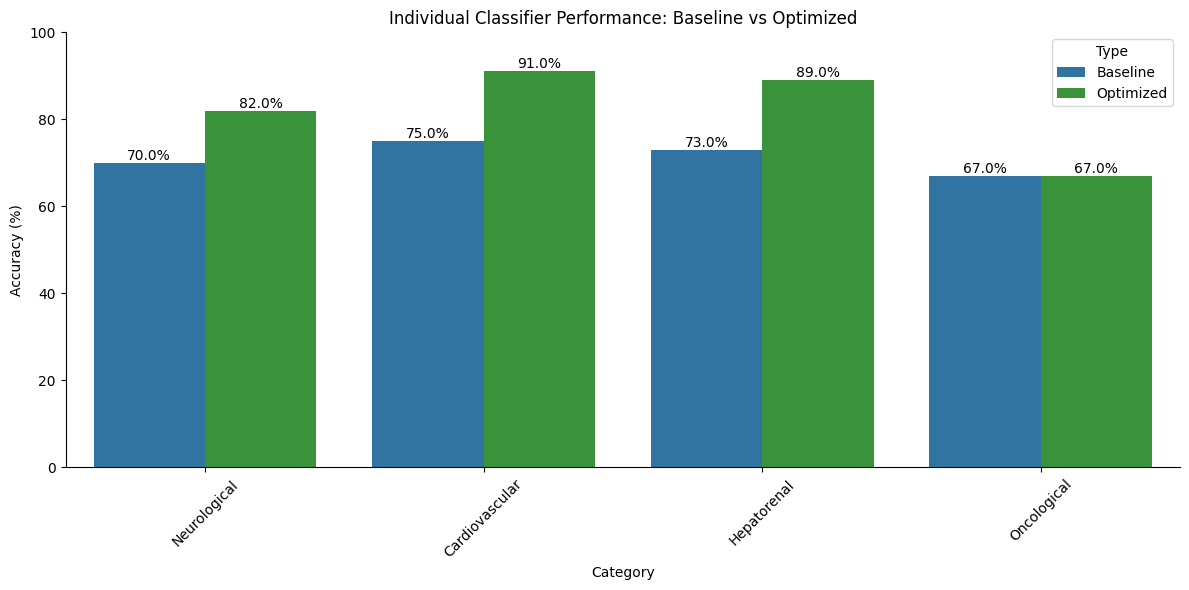

In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create comparison data
comparison_data = []
for category in ['neurological', 'cardiovascular', 'hepatorenal', 'oncological']:
    comparison_data.append({
        'Category': category.capitalize(),
        'Type': 'Baseline',
        'Accuracy': baseline_scores[category]
    })
    comparison_data.append({
        'Category': category.capitalize(),
        'Type': 'Optimized', 
        'Accuracy': optimized_scores[category]
    })

df = pd.DataFrame(comparison_data)

# Create visualization
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df,
    x='Category',
    y='Accuracy',
    hue='Type',
    palette=['#1f77b4', '#2ca02c']
)

ax.set_ylim(0, 100)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Individual Classifier Performance: Baseline vs Optimized')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()


## 6. Save & Load DSPy Programs

### Saving DSPy Programs

In [ ]:
# Save individual baseline classifiers
for category, classifier in classifiers.items():
    classifier.save(f"../{PROGRAMS_FOLDER}/{category}_classifier_base.json", save_program=False)
    print(f"Saved {category}_classifier_base.json to {PROGRAMS_FOLDER}")

# Save individual optimized classifiers  
for category, classifier in optimized_classifiers.items():
    classifier.save(f"../{PROGRAMS_FOLDER}/{category}_classifier_optimized.json", save_program=False)
    print(f"Saved {category}_classifier_optimized.json to {PROGRAMS_FOLDER}")

Saved neurological_classifier_base.json to programs
Saved cardiovascular_classifier_base.json to programs
Saved hepatorenal_classifier_base.json to programs
Saved oncological_classifier_base.json to programs
Saved neurological_classifier_optimized.json to programs
Saved cardiovascular_classifier_optimized.json to programs
Saved hepatorenal_classifier_optimized.json to programs
Saved oncological_classifier_optimized.json to programs


### Loading DSPy Programs

In [24]:
# Combined classifier for inference (using optimized individual classifiers)
class CombinedBiomedicClassifier:
    def __init__(self, classifiers_dict):
        self.classifiers = classifiers_dict
    
    def __call__(self, title, abstract):
        """Run all 4 optimized classifiers and return combined results."""
        results = dspy.Example()
        
        # Neurological
        neuro_pred = self.classifiers['neurological'](title=title, abstract=abstract)
        results.neurological = getattr(neuro_pred, 'is_neurological', False)
        
        # Cardiovascular  
        cardio_pred = self.classifiers['cardiovascular'](title=title, abstract=abstract)
        results.cardiovascular = getattr(cardio_pred, 'is_cardiovascular', False)
        
        # Hepatorenal
        hepato_pred = self.classifiers['hepatorenal'](title=title, abstract=abstract)
        results.hepatorenal = getattr(hepato_pred, 'is_hepatorenal', False)
        
        # Oncological
        onco_pred = self.classifiers['oncological'](title=title, abstract=abstract)
        results.oncological = getattr(onco_pred, 'is_oncological', False)
        
        return results

# Create optimized combined classifier for easy inference
optimized_combined_classifier = CombinedBiomedicClassifier(optimized_classifiers)

print("✅ Created combined classifier using individually optimized models")
print("📝 Use individual classifiers for focused tasks or combined for full classification")

# Load baseline classifiers
loaded_base_classifiers = {}
signatures = {
    'neurological': NeurologicalClassifier,
    'cardiovascular': CardiovascularClassifier, 
    'hepatorenal': HepatoRenalClassifier,
    'oncological': OncologicalClassifier
}

for category, signature in signatures.items():
    classifier = dspy.ChainOfThought(signature)
    classifier.load(f"../{PROGRAMS_FOLDER}/{category}_classifier_base.json")
    loaded_base_classifiers[category] = classifier

# Load optimized classifiers
loaded_optimized_classifiers = {}
for category, signature in signatures.items():
    classifier = dspy.ChainOfThought(signature)
    classifier.load(f"../{PROGRAMS_FOLDER}/{category}_classifier_optimized.json")
    loaded_optimized_classifiers[category] = classifier

# Create combined classifiers
loaded_base_combined = CombinedBiomedicClassifier(loaded_base_classifiers)
loaded_optimized_combined = CombinedBiomedicClassifier(loaded_optimized_classifiers)

print("\nSuccessfully loaded all DSPy programs:")
for category in signatures.keys():
    print(f"   - {category} baseline: {PROGRAMS_FOLDER}/{category}_classifier_base.json")
    print(f"   - {category} optimized: {PROGRAMS_FOLDER}/{category}_classifier_optimized.json")


✅ Created combined classifier using individually optimized models
📝 Use individual classifiers for focused tasks or combined for full classification


KeyError: 'predict'

## 📏 Contest Requirements: Weighted F1 Score & Confusion Matrix

Implementation of contest evaluation metrics for biomedical papers classification.


In [25]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

def evaluate_optimized_model_with_metrics(valset, classifier):
    """Evaluate optimized model with weighted F1 and confusion matrices"""
    
    # Categories
    categories = ['neurological', 'cardiovascular', 'hepatorenal', 'oncological']
    
    # Collect predictions and true labels
    y_true = {cat: [] for cat in categories}
    y_pred = {cat: [] for cat in categories}
    
    print("🔄 Running predictions on validation set...")
    for i, example in enumerate(valset):
        # Get prediction from combined classifier
        pred = classifier(title=example.title, abstract=example.abstract)
        
        # Collect true and predicted values
        for cat in categories:
            y_true[cat].append(getattr(example, cat))
            y_pred[cat].append(getattr(pred, cat))
    
    # Calculate metrics for each category
    results = {}
    
    print("\n📊 WEIGHTED F1 SCORES BY CATEGORY:")
    print("=" * 50)
    
    for cat in categories:
        # F1 score (weighted for binary is same as regular F1)
        f1 = f1_score(y_true[cat], y_pred[cat], average='weighted')
        results[f'{cat}_f1'] = f1
        
        print(f"{cat.capitalize()}: {f1:.4f}")
    
    # Overall weighted F1 (macro average across categories)
    overall_f1 = np.mean([results[f'{cat}_f1'] for cat in categories])
    results['overall_weighted_f1'] = overall_f1
    
    print(f"\n🎯 OVERALL WEIGHTED F1 SCORE: {overall_f1:.4f}")
    
    # Confusion matrices
    print("\n📈 CONFUSION MATRICES:")
    print("=" * 50)
    
    for cat in categories:
        cm = confusion_matrix(y_true[cat], y_pred[cat])
        print(f"\n{cat.upper()} CONFUSION MATRIX:")
        print(f"       Predicted")
        print(f"       F    T")
        print(f"True F {cm[0,0]:3d}  {cm[0,1]:3d}")
        print(f"     T {cm[1,0]:3d}  {cm[1,1]:3d}")
        
        # Store confusion matrix
        results[f'{cat}_confusion_matrix'] = cm
    
    return results

# Run evaluation with contest metrics
contest_results = evaluate_optimized_model_with_metrics(dspy_valset, optimized_combined_classifier)


🔄 Running predictions on validation set...

📊 WEIGHTED F1 SCORES BY CATEGORY:
Neurological: 0.8185
Cardiovascular: 0.9110
Hepatorenal: 0.8869
Oncological: 0.7317

🎯 OVERALL WEIGHTED F1 SCORE: 0.8370

📈 CONFUSION MATRICES:

NEUROLOGICAL CONFUSION MATRIX:
       Predicted
       F    T
True F  48    6
     T  12   34

CARDIOVASCULAR CONFUSION MATRIX:
       Predicted
       F    T
True F  62    6
     T   3   29

HEPATORENAL CONFUSION MATRIX:
       Predicted
       F    T
True F  62    2
     T   9   27

ONCOLOGICAL CONFUSION MATRIX:
       Predicted
       F    T
True F  58   31
     T   2    9


[Trace(trace_id=tr-948612cf561042205da690764d24279b), Trace(trace_id=tr-4118b1b2afdb9aa4b09e299f79938174), Trace(trace_id=tr-f248e8b3bfc56107811c50eaf2c3c4a3), Trace(trace_id=tr-79fb8f0d728ad9ae82e58fcfe5bf534f), Trace(trace_id=tr-b5d334b8cce4d822b233122ba36ade2b), Trace(trace_id=tr-d6d524c04e5a23069f9921fb7b8cf2bd), Trace(trace_id=tr-1a472123b2cd271c075d16f28a3cbf6e), Trace(trace_id=tr-2b05118ff30573761b2943c9bed13310), Trace(trace_id=tr-1f7054555ef06b3b236b0f1a3de22637), Trace(trace_id=tr-b5b49c6a8af8a3cab8b2fdc7cf9e0a31)]

In [26]:
# Quick access to contest results
print("=" * 60)
print("🏆 CONTEST SUBMISSION SUMMARY")
print("=" * 60)
print(f"✅ Overall Weighted F1 Score: {contest_results['overall_weighted_f1']:.4f}")
print("\n📋 Category F1 Scores:")
for cat in ['neurological', 'cardiovascular', 'hepatorenal', 'oncological']:
    print(f"   • {cat.capitalize()}: {contest_results[f'{cat}_f1']:.4f}")
print("\n✅ Confusion matrices generated for all categories")
print("=" * 60)


🏆 CONTEST SUBMISSION SUMMARY
✅ Overall Weighted F1 Score: 0.8370

📋 Category F1 Scores:
   • Neurological: 0.8185
   • Cardiovascular: 0.9110
   • Hepatorenal: 0.8869
   • Oncological: 0.7317

✅ Confusion matrices generated for all categories
